In [471]:
%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import causallearn
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
import random
from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.experiments.Evaluator import Evaluator
from clustercausal.utils.Utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Keep the names of the nodes in the clusters in  the same order as they are being generated for the data, otherwise the algorithm will confuse the data column ordering and node ordering. 

ClusterFCI doesn't support custom node names yet. If looking at the verbose output of FCI and C-FCI, remember that 'X1' corresponds to node '0', 'X2' to node '1', etc. . This is due to numpy array indexing. 

In [472]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C2'), ('C2', 'C3')], \
                         cluster_bidirected_edges=[('C2', 'C3')])
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6'], 'C4' : ['X7', 'X8']}, \
                         cluster_edges = [('C1', 'C2'), ('C2', 'C3'), ('C1', 'C4')], \
                         cluster_bidirected_edges=[('C2', 'C3'), ('C3', 'C4')])

In [473]:
# for c_name in cluster_dag.cluster_mapping.keys():
#     for bidir_edge in cluster_dag.cluster_bidirected_edges:
#         if c_name == bidir_edge[0]:
#             cluster_dag.cluster_mapping[c_name].append(bidir_edge[1])
#         elif c_name == bidir_edge[1]:
#             cluster_dag.cluster_mapping[c_name].append(bidir_edge[0])

In [474]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
#                          cluster_edges = [('C1', 'C3'), ('C2', 'C3')])

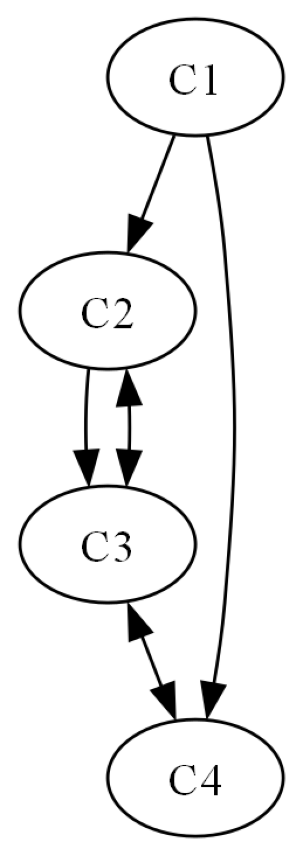

In [475]:
cluster_dag.cluster_graph.draw_pydot_graph()

Found inducing path between C1 and C3: ['C1', 'C2', 'C3']


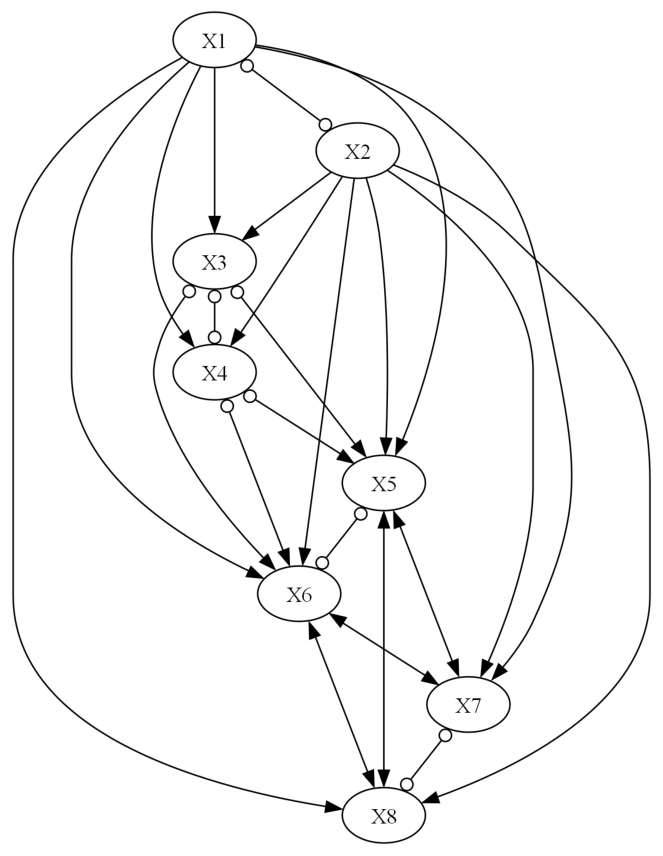

In [476]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [477]:
cluster_dag.bidir_paths

{'C1': [['C1']],
 'C2': [['C2'], ['C2', 'C3'], ['C2', 'C3', 'C4']],
 'C3': [['C3'], ['C3', 'C2'], ['C3', 'C4']],
 'C4': [['C4'], ['C4', 'C3'], ['C4', 'C3', 'C2']]}

In [478]:
cluster_dag.collider_paths

{'C1': [['C1'],
  ['C1', 'C2'],
  ['C1', 'C2', 'C3'],
  ['C1', 'C2', 'C3', 'C4'],
  ['C1', 'C4'],
  ['C1', 'C4', 'C3'],
  ['C1', 'C4', 'C3', 'C2']],
 'C2': [['C2'], ['C2', 'C3'], ['C2', 'C3', 'C4'], ['C2', 'C3', 'C4', 'C1']],
 'C3': [['C3'], ['C3', 'C2'], ['C3', 'C4']],
 'C4': [['C4'], ['C4', 'C3'], ['C4', 'C3', 'C2']]}

In [479]:
cluster_dag.cluster_ancestors

{'C1': [], 'C2': ['C1'], 'C3': ['C2', 'C1'], 'C4': ['C1']}

In [480]:
cluster_dag.get_cluster_topological_ordering()

['C1', 'C2', 'C4', 'C3']

Simple FCI test

### 3 node FCI

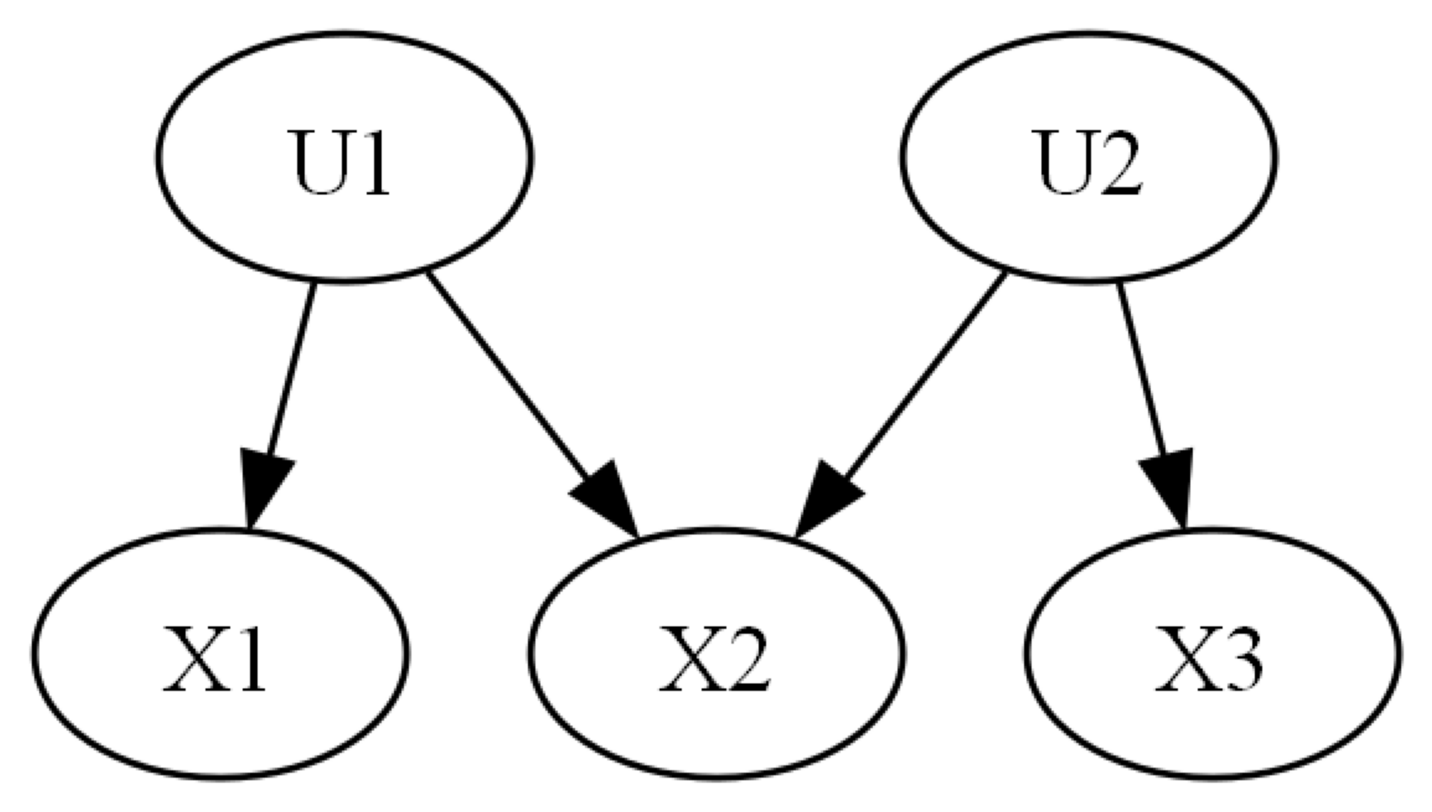

In [481]:
# List of node names
node_names = ["X1", "X2", "X3", "U1", "U2"]

# Parent dictionary
# parent_dict must be in topological ordering
parent_dict = {
    "X1": ["U1"],               # X1 has no parents
    "X2": ["U1", "U2"],           # X2 has X1 as a parent
    "X3": ["U2"],
    "U1": [],
    "U2": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [482]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([ 2.01974401,  1.15061218,  0.41353516,  1.52302986, -0.23415337])

In [483]:
# remove confounders from X
X = X[:,:3]
X

array([[ 2.01974401,  1.15061218,  0.41353516],
       [-0.70361134,  1.65229847,  1.30999477],
       [-2.37669794, -4.10392783, -1.48295556],
       ...,
       [ 2.29221043,  3.13377535,  0.55856252],
       [ 1.70750982, -1.71298002, -2.82726854],
       [ 0.32201439,  1.75610359,  2.01589587]])

In [484]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3']}, cluster_edges = [])
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' :['X3']}, cluster_edges = [], cluster_bidirected_edges=[('C1', 'C2')])

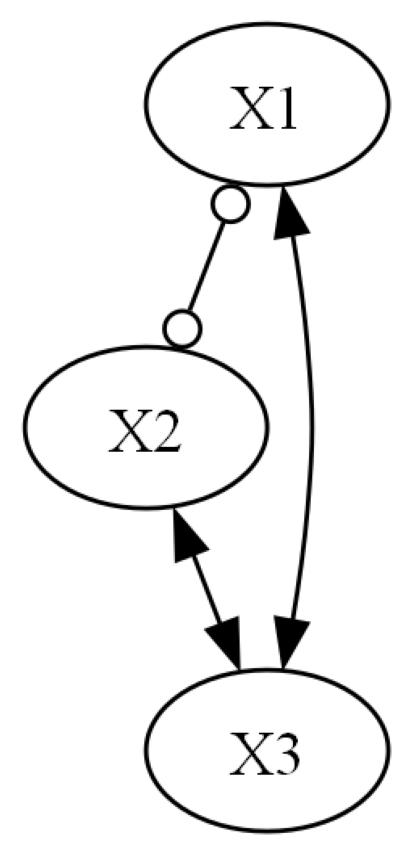

In [485]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [486]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [487]:
cluster_cg, cluster_edges = cluster_fci.run()

C2 phase, Depth=0, working on node 2: 100%|██████████| 1/1 [00:00<?, ?it/s, duration: 0.02sec]


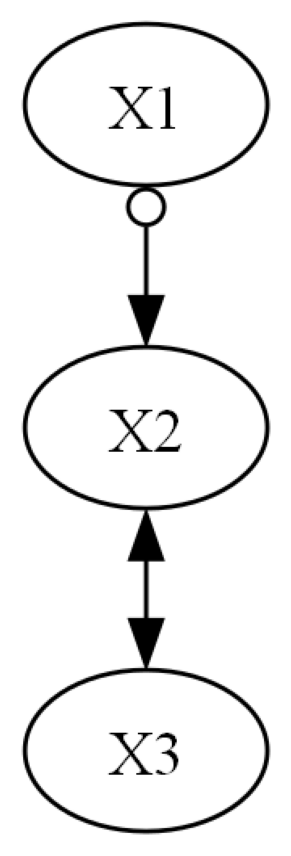

In [488]:
cluster_cg.draw_pydot_graph()

In [489]:
from causallearn.search.ConstraintBased.FCI import fci

In [490]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(3, )
node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<?, ?it/s]         

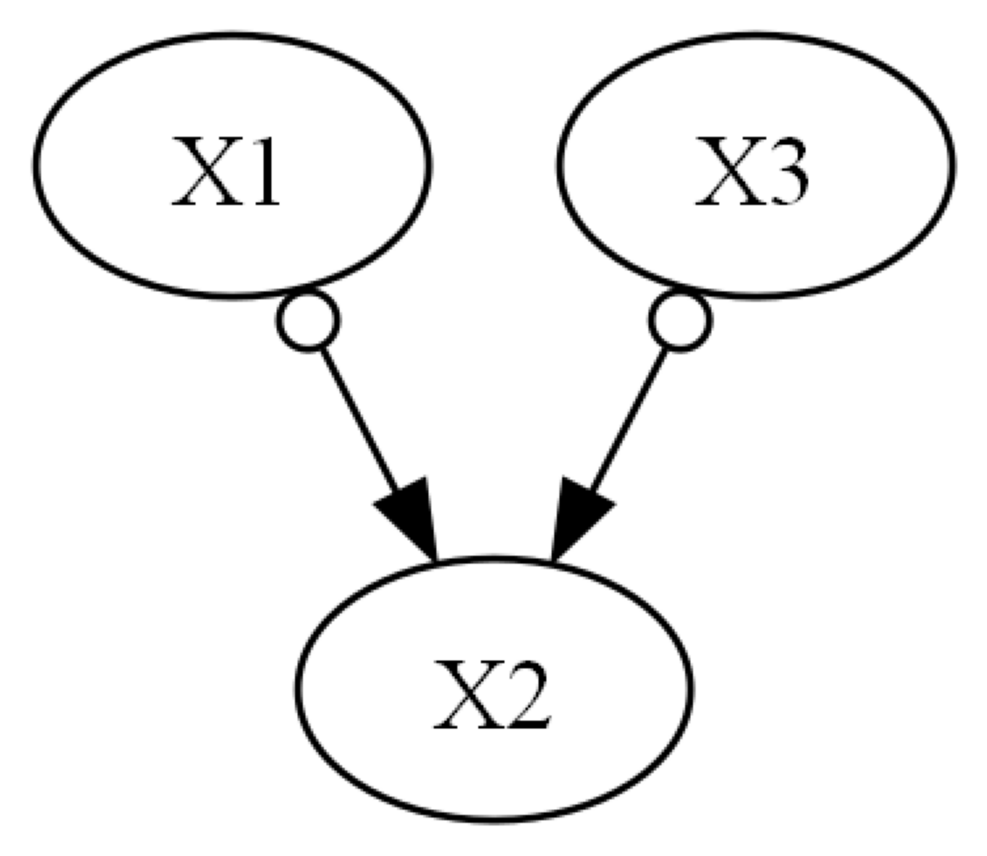

In [491]:
base_cg.draw_pydot_graph()

### 4 node FCI

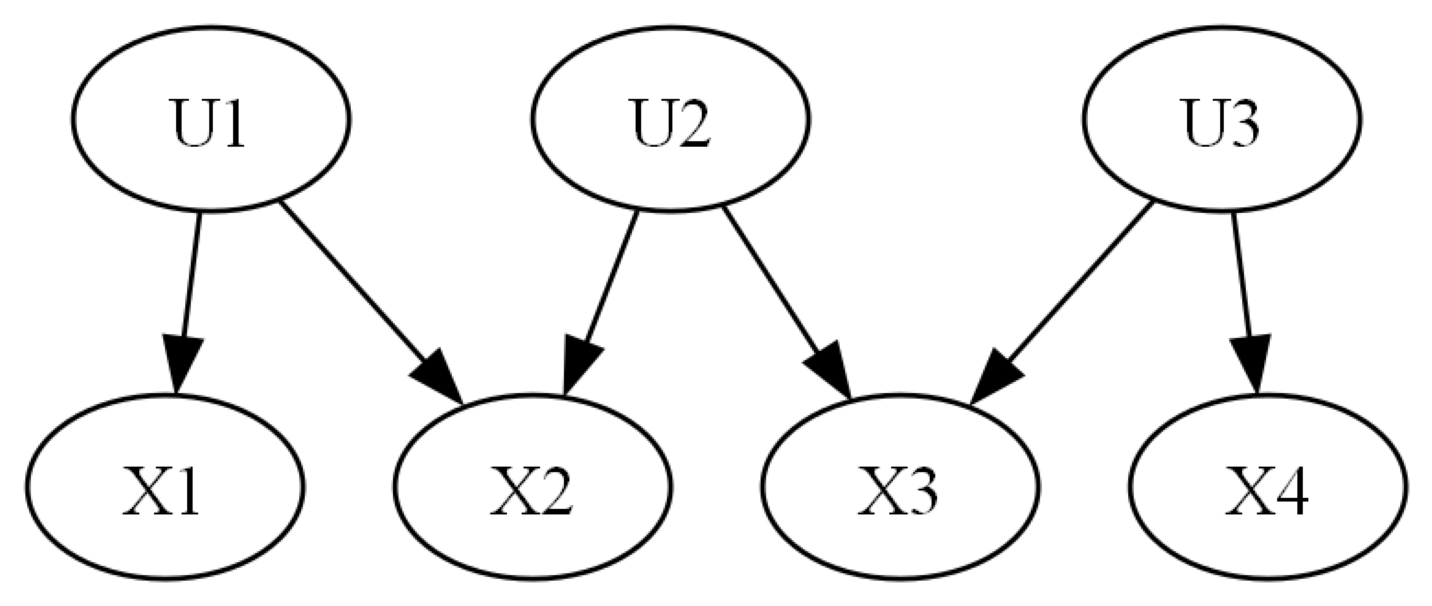

In [492]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "U1", "U2", "U3"]

# Parent dictionary
parent_dict = {
    "X1": ["U1"],               # X1 has no parents
    "X2": ["U1", "U2"],           # X2 has X1 as a parent
    "X3": ["U2", "U3"],           # X3 has X1 as a parent
    "X4": ["U3"],
    "U1": [],
    "U2": [],
    "U3": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [493]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([ 0.26256078, -0.60655463,  1.9927644 ,  3.10224267, -0.23415337,
       -0.23413696,  1.57921282])

In [494]:
# remove confounders from X
X = X[:,:4]
X

array([[ 0.26256078, -0.60655463,  1.9927644 ,  3.10224267],
       [ 0.30170498, -0.69324187, -1.12875793, -2.37669794],
       [-2.63294191, -2.88261531, -0.95948605,  1.7798961 ],
       ...,
       [-0.77880783, -2.21262061, -0.09957637,  1.35603184],
       [ 0.63152595, -0.68866676,  1.30867665,  1.80940473],
       [ 0.99302981, -0.43395547, -1.40977871, -0.99839204]])

In [495]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3', 'X4']}, cluster_edges = [])
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3'], 'C2': ['X4']}, cluster_edges = [], \
                         cluster_bidirected_edges=[('C1', 'C2')])

In [496]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [497]:
cluster_cg, cluster_edges = cluster_fci.run()

C2 phase, Depth=0, working on node 3: 100%|██████████| 1/1 [00:00<?, ?it/s, duration: 0.02sec]


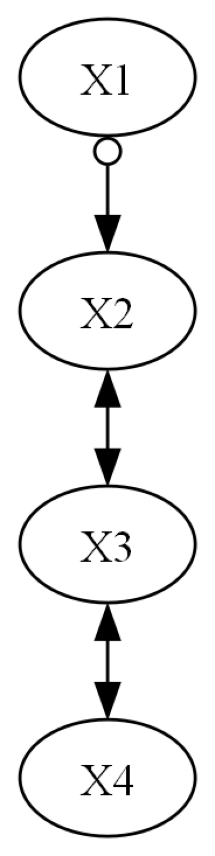

In [498]:
cluster_cg.draw_pydot_graph()

In [499]:
from causallearn.search.ConstraintBased.FCI import fci

In [500]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(3, )
node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=1, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 266.97it/s]

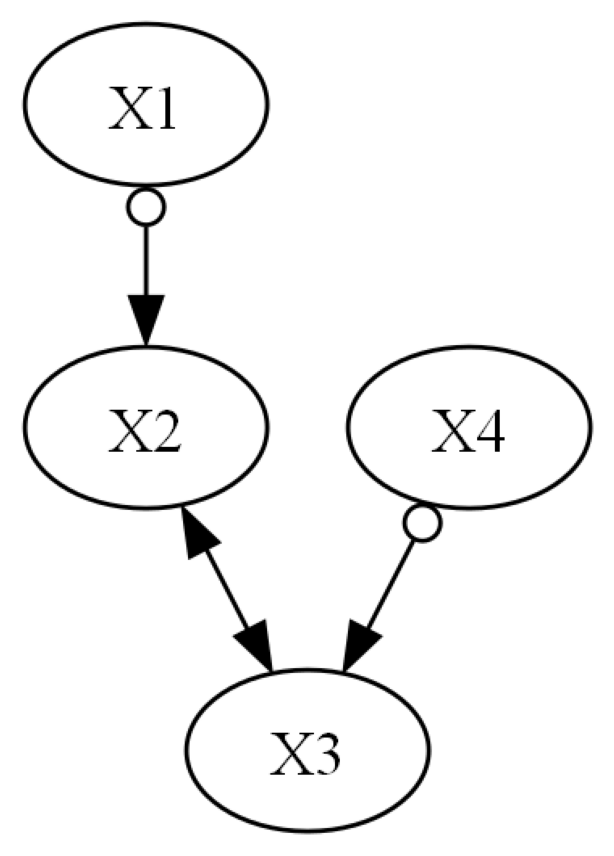

In [501]:
base_cg.draw_pydot_graph()

### 5 node FCI No.1

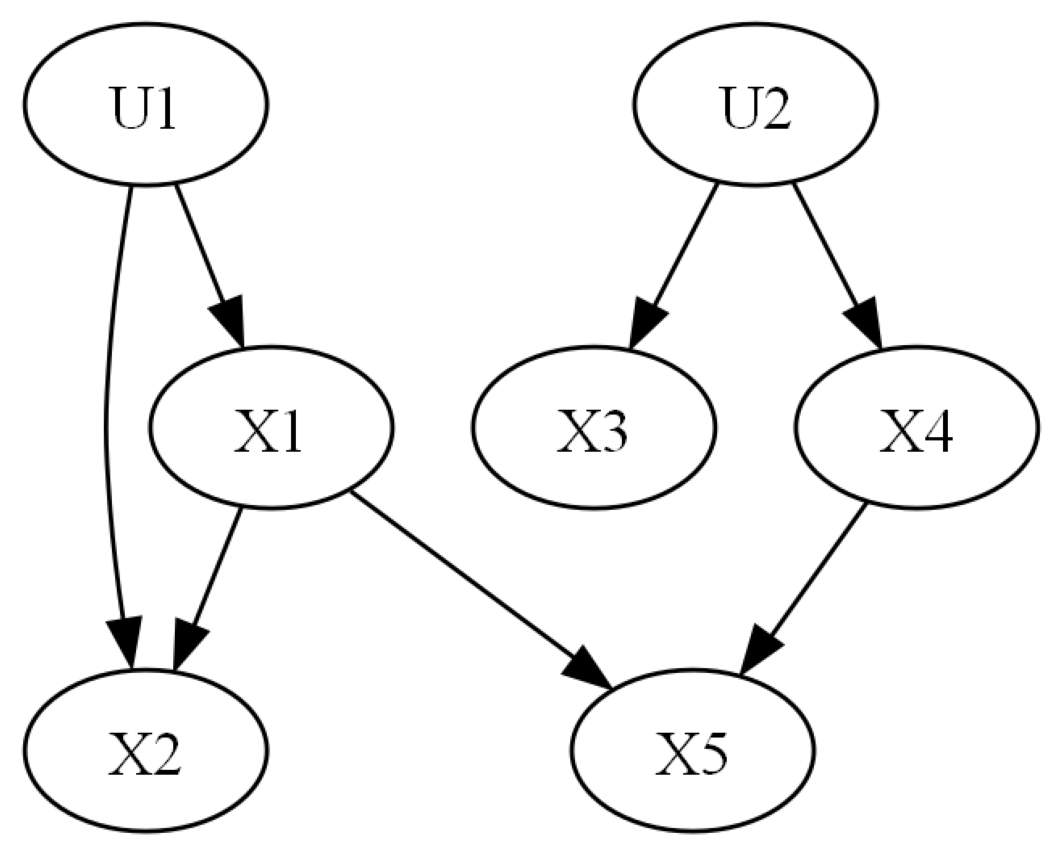

In [502]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "X5", "U1", "U2"]

# Parent dictionary
parent_dict = {
    "X1": ["U1"],               
    "X2": ["X1", "U1"],           
    "X3": ["U2"],           
    "X4": ["U2"],
    "X5": ["X1", "X4"],
    "U1": [],
    "U2": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [503]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([ 0.2625772 , -0.10982406,  2.22690135,  3.10224267,  3.13066649,
       -0.23413696,  1.57921282])

In [504]:
# remove confounders from X
X = X[:,:5]
X

array([[ 0.2625772 , -0.10982406,  2.22690135,  3.10224267,  3.13066649],
       [ 1.009397  ,  0.78188489, -1.3707202 , -2.37669794, -1.83303069],
       [-3.13722153, -5.11181276,  0.45281765,  1.7798961 , -2.26534951],
       ...,
       [-1.59892848, -3.44051812,  1.09157525,  1.35603184, -0.61392761],
       [ 0.52295022,  0.29091925,  1.87388818,  1.80940473,  1.87571916],
       [ 1.15302764,  0.35114724, -1.93770146, -0.99839204,  0.52256052]])

In [505]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3', 'X4', 'X5']}, cluster_edges = [])
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4', 'X5']}, cluster_edges = [('C1', 'C2')], \
                         cluster_bidirected_edges=[])

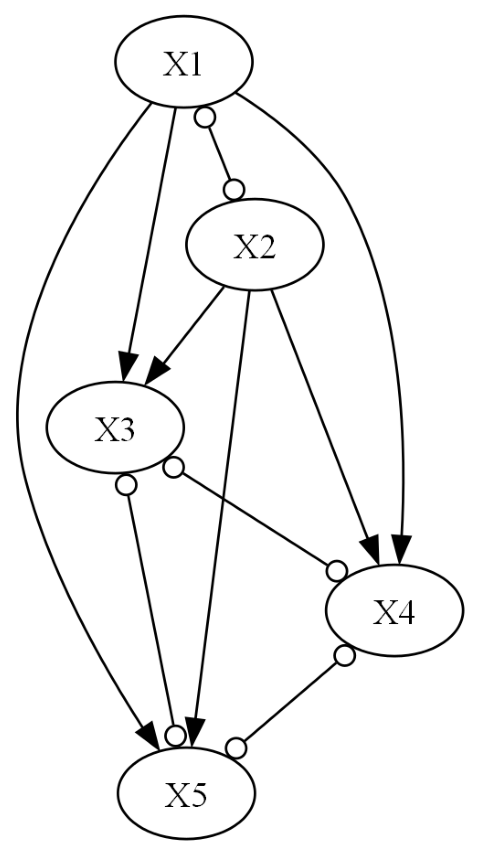

In [506]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [507]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [508]:
cluster_cg, cluster_edges = cluster_fci.run()

C2 phase, Depth=1, working on node 4: 100%|██████████| 3/3 [00:00<00:00, 192.00it/s, duration: 0.03sec]


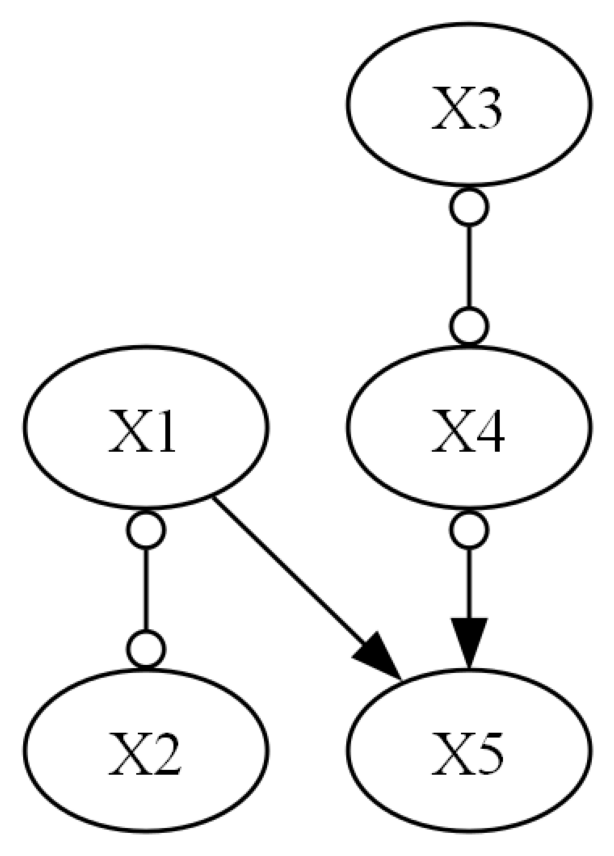

In [509]:
cluster_cg.draw_pydot_graph()

In [510]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(5)
# node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=1, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 286.72it/s]

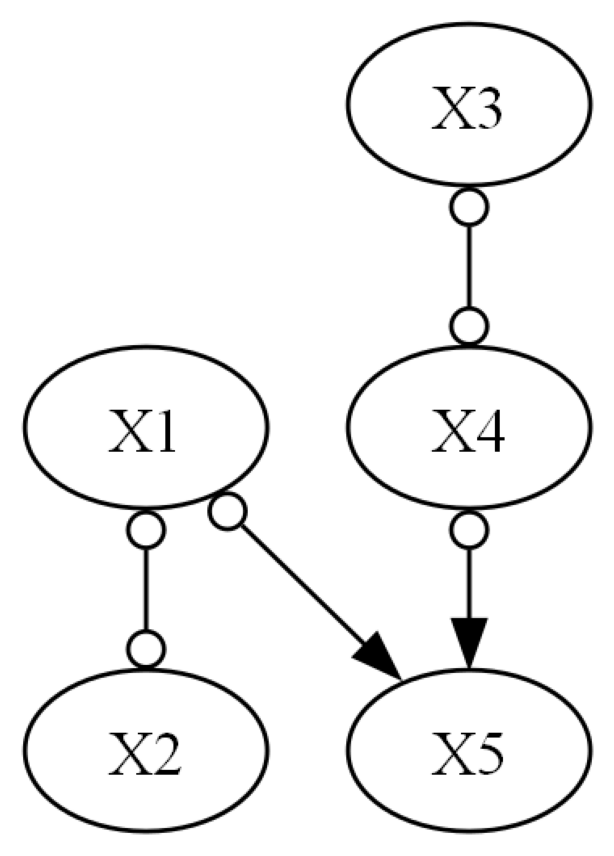

In [511]:
base_cg.draw_pydot_graph()

### 6 node FCI No.1

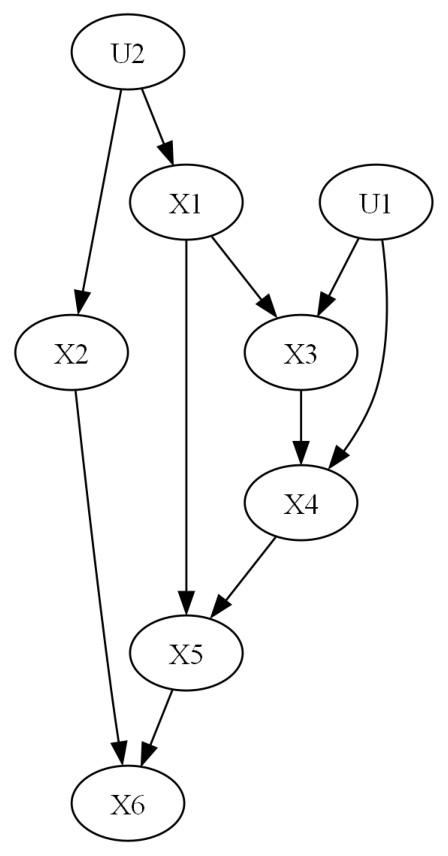

In [512]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "X5", "X6", "U1", "U2"]

# Parent dictionary
# Make sure nodes are put into topological ordering
parent_dict = {
    "X1": ["U2"],           
    "X2": ["U2"],
    "X3": ["U1", "X1"],               
    "X4": ["X3", "U1"], 
    "X5": ["X1", "X4"],
    "X6": ["X2", "X5"],
    "U1": [],
    "U2": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [513]:
true_mag = truth
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U1', cg = truth))
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U2', cg = truth))
# Add edge due to inducing path
node1 = ClusterDAG.get_node_by_name('X1', cg = truth)
node2 = ClusterDAG.get_node_by_name('X4', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.TAIL, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)
# Add bidirected edge due to latent confounding
node1 = ClusterDAG.get_node_by_name('X1', cg = truth)
node2 = ClusterDAG.get_node_by_name('X2', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)

True

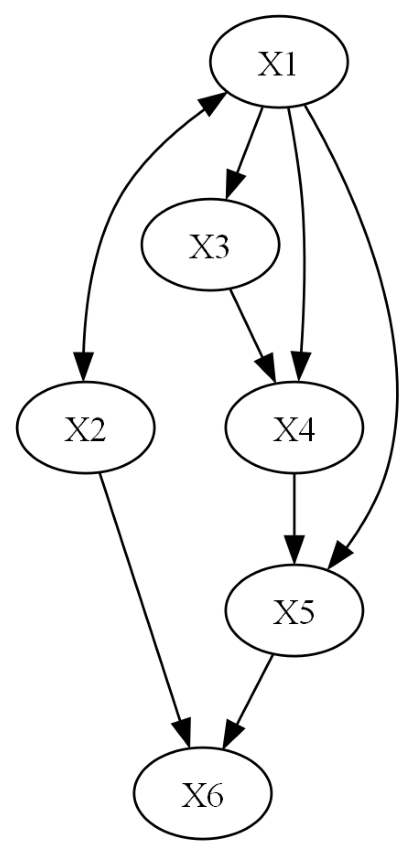

In [514]:
true_mag.draw_pydot_graph()

In [515]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([1.26414888, 0.62917043, 3.49105024, 6.59329291, 7.62328842,
       8.01832189, 1.57921282, 0.76743473])

In [516]:
# remove confounders from X
X = X[:,:6]
X

array([[ 1.26414888,  0.62917043,  3.49105024,  6.59329291,  7.62328842,
         8.01832189],
       [-1.03176192, -0.01972749, -3.22009744, -5.41074503, -6.20054467,
        -8.1335524 ],
       [-2.43757931, -1.11050085, -3.27807518, -4.62285067, -5.59478121,
        -6.93105837],
       ...,
       [ 0.72333001,  0.83390522,  1.65871638,  2.18126592,  2.45222444,
         4.29334771],
       [-2.92327116, -1.66654366, -0.91912746, -0.08885745, -3.11737733,
        -5.18740362],
       [-2.42791104, -0.43020362, -1.57591246, -0.63839046, -3.49562021,
        -4.39478084]])

In [517]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']}, \
#                          cluster_edges = [])

In [518]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4', 'X5', 'X6']}, \
#                          cluster_edges = [('C1', 'C2')])

In [519]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C2'), ('C2', 'C3'), ('C1', 'C3')], \
                         cluster_bidirected_edges= [])

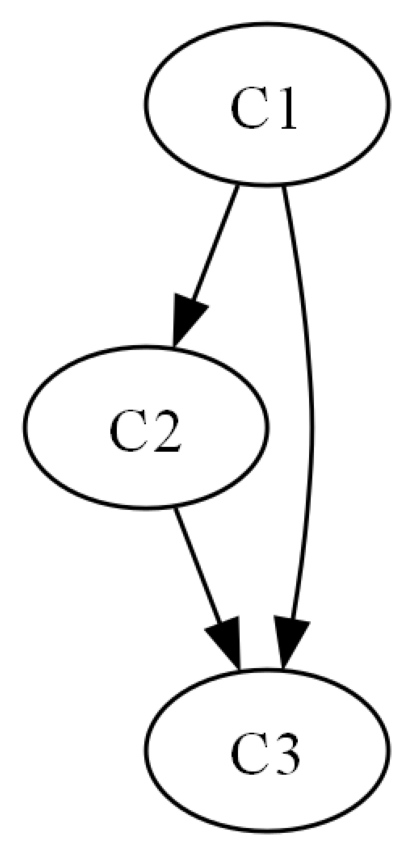

In [520]:
cluster_dag.cluster_graph.draw_pydot_graph()

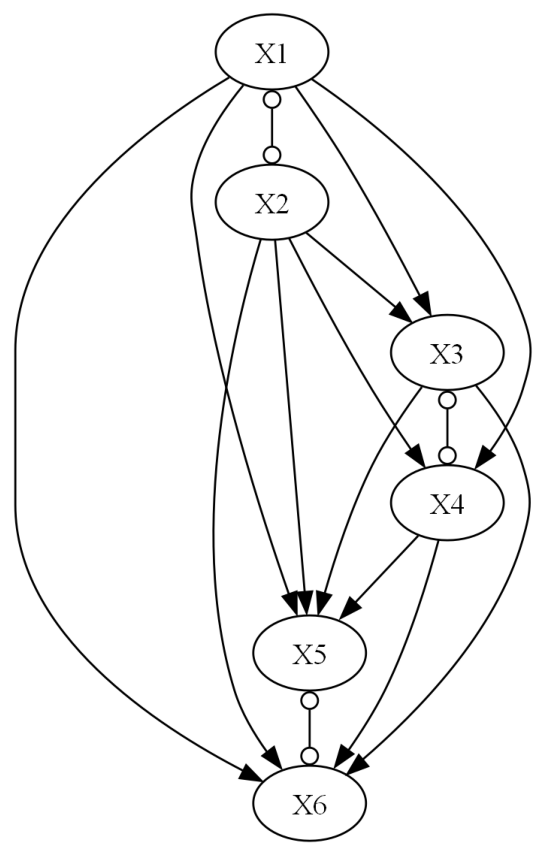

In [521]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [522]:
cluster_dag.bidir_paths

{'C1': [['C1']], 'C2': [['C2']], 'C3': [['C3']]}

In [523]:
cluster_dag.collider_paths

{'C1': [['C1'], ['C1', 'C2'], ['C1', 'C3'], ['C1', 'C3', 'C2']],
 'C2': [['C2'], ['C2', 'C3'], ['C2', 'C3', 'C1']],
 'C3': [['C3']]}

In [524]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [525]:
cluster_cg, cluster_edges = cluster_fci.run()

C3 phase, Depth=2, working on node 5: 100%|██████████| 2/2 [00:00<00:00, 80.80it/s, duration: 0.07sec]

X4 --> X5
X5 --> X6


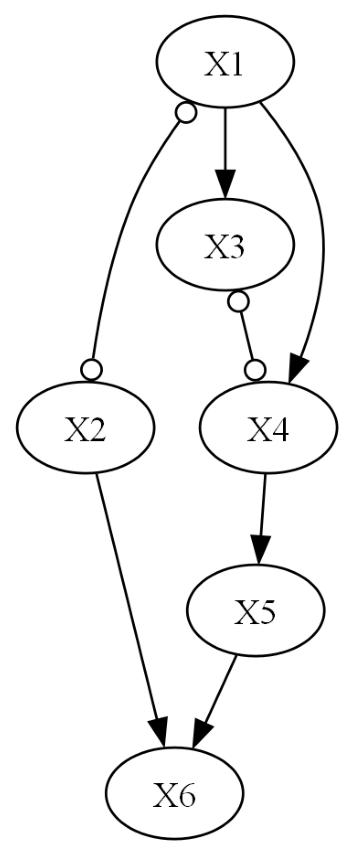

In [526]:
cluster_cg.draw_pydot_graph()

In [527]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(5)
# node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 171.27it/s] 

X4 --> X3


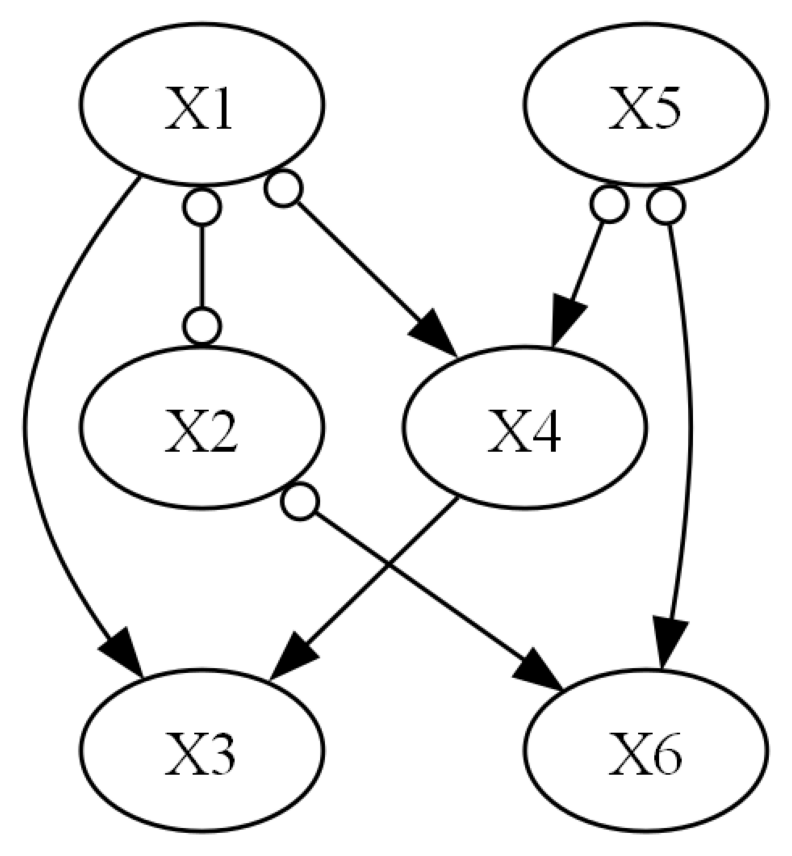

In [528]:
base_cg.draw_pydot_graph()

SID is set to false, as SID is not defined for PAGs. Its outputs do not make sense. 

In [529]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 7, 'false_positive': 0, 'false_negative': 1, 'true_negative': 7, 'precision': 1.0, 'recall': 0.875, 'f1_score': 0.9333333333333333}
Arrow confusion:  {'true_positive': 4.0, 'false_positive': 2.0, 'false_negative': 5.0, 'true_negative': 25.0, 'precision': 0.6666666666666666, 'recall': 0.4444444444444444, 'f1_score': 0.5333333333333333, 'true_positive_ce': 4.0, 'false_positive_ce': 2.0, 'false_negative_ce': 4.0, 'true_negative_ce': 26.0, 'precision_ce': 0.6666666666666666, 'recall_ce': 0.5, 'f1_score_ce': 0.5714285714285715}
SHD:  3
SID:  {'sid_lower': None}


In [530]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 7, 'false_positive': 0, 'false_negative': 1, 'true_negative': 7, 'precision': 1.0, 'recall': 0.875, 'f1_score': 0.9333333333333333}
Arrow confusion:  {'true_positive': 5.0, 'false_positive': 0.0, 'false_negative': 4.0, 'true_negative': 27.0, 'precision': 1.0, 'recall': 0.5555555555555556, 'f1_score': 0.7142857142857143, 'true_positive_ce': 5.0, 'false_positive_ce': 0.0, 'false_negative_ce': 3.0, 'true_negative_ce': 28.0, 'precision_ce': 1.0, 'recall_ce': 0.625, 'f1_score_ce': 0.7692307692307693}
SHD:  1
SID:  {'sid_lower': None}


### 6 node FCI No.2

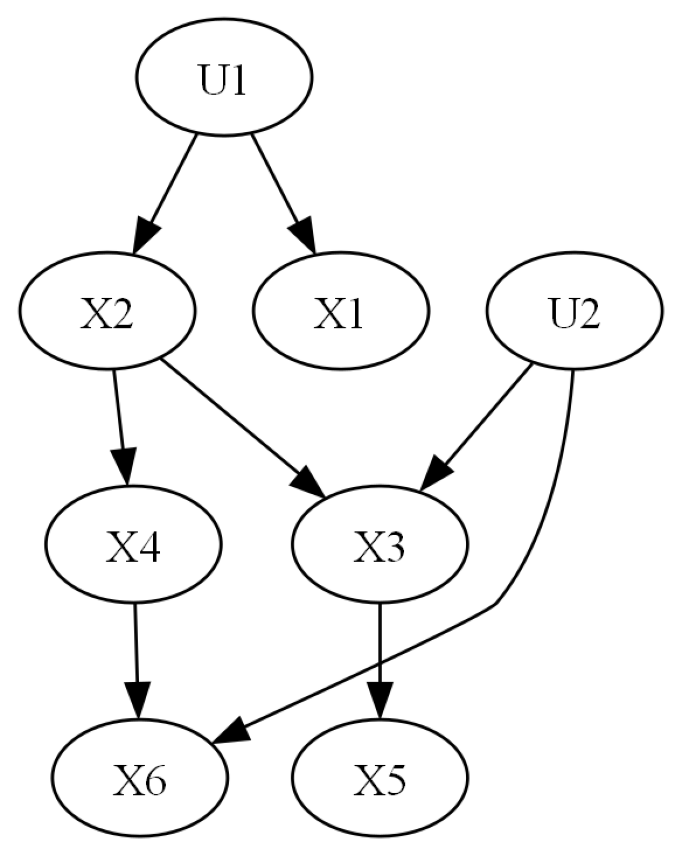

In [531]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "X5", "X6", "U1", "U2"]

# Parent dictionary
# Make sure nodes are put into topological ordering
parent_dict = {
    "X1": ["U1"],           
    "X2": ["U1"],
    "X3": ["X2", "U2"],               
    "X4": ["X2"], 
    "X5": ["X3"],
    "X6": ["X4", "U2"],
    "U1": [],
    "U2": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [532]:
true_mag = truth
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U1', cg = truth))
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U2', cg = truth))
# Add edge due to inducing path
node1 = ClusterDAG.get_node_by_name('X3', cg = truth)
node2 = ClusterDAG.get_node_by_name('X6', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)
# Add bidirected edge due to latent confounding
node1 = ClusterDAG.get_node_by_name('X1', cg = truth)
node2 = ClusterDAG.get_node_by_name('X2', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)

True

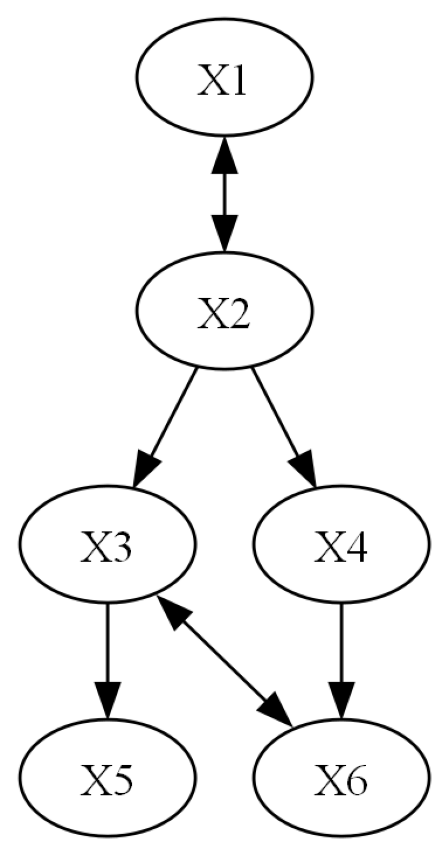

In [533]:
true_mag.draw_pydot_graph()

In [534]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([2.07592697, 1.44094851, 2.85607178, 2.96397837, 2.62191841,
       3.49727614, 1.57921282, 0.76743473])

In [535]:
# remove confounders from X
X = X[:,:6]
X

array([[ 2.07592697,  1.44094851,  2.85607178,  2.96397837,  2.62191841,
         3.49727614],
       [-2.19439222, -1.18235779, -2.20806301, -1.64808754, -1.96610074,
        -4.12365532],
       [-0.94530292,  0.38177554, -1.95099672, -1.03052816, -0.48534796,
        -2.68105265],
       ...,
       [-0.88205414, -0.77147893,  1.76929159, -0.49269816,  1.3169201 ,
         2.36367281],
       [-1.42863195, -0.17190446,  0.33760004,  0.30854216,  0.23235131,
        -1.23975628],
       [-1.43776579,  0.55994163,  0.42179496,  1.50080641, -0.00752374,
         0.03836136]])

In [536]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']}, \
#                          cluster_edges = [])

In [537]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4', 'X5', 'X6']}, \
#                          cluster_edges = [('C1', 'C2')])

In [538]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C2'), ('C2', 'C3')], \
                         cluster_bidirected_edges= [('C2', 'C3')])

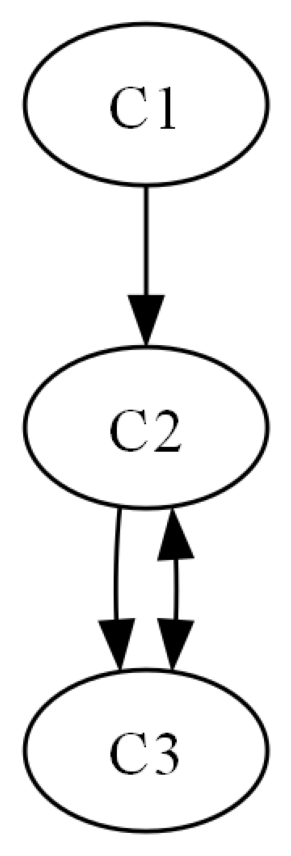

In [539]:
cluster_dag.cluster_graph.draw_pydot_graph()

Found inducing path between C1 and C3: ['C1', 'C2', 'C3']


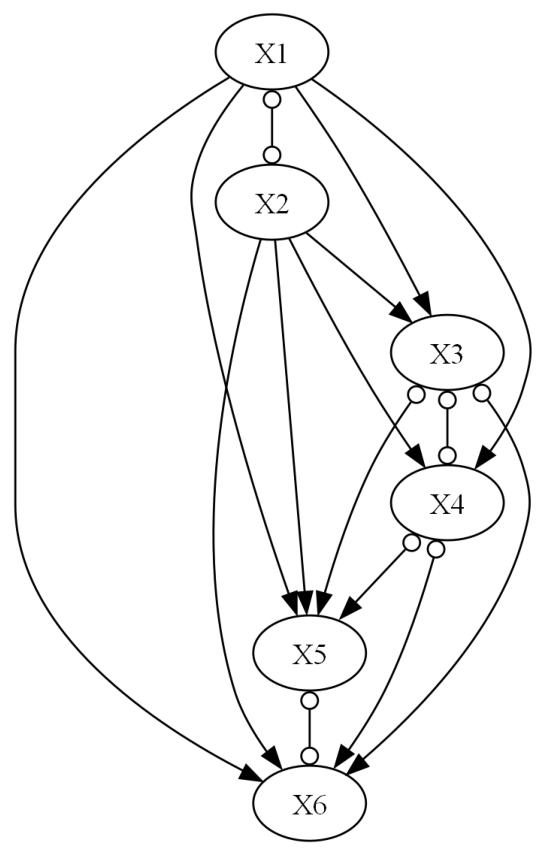

In [540]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [541]:
cluster_dag.bidir_paths

{'C1': [['C1']], 'C2': [['C2'], ['C2', 'C3']], 'C3': [['C3'], ['C3', 'C2']]}

In [542]:
cluster_dag.collider_paths

{'C1': [['C1'], ['C1', 'C2'], ['C1', 'C2', 'C3']],
 'C2': [['C2'], ['C2', 'C3']],
 'C3': [['C3'], ['C3', 'C2']]}

In [576]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [544]:
cluster_cg, cluster_edges = cluster_fci.run()

Topological ordering ['C1', 'C2', 'C3']
Cluster node indices of C1 are [0 1]
Local graph node indices of C1 are [0 1]


C1 phase, Depth=0, working on node 1: 100%|██████████| 2/2 [00:00<00:00, 125.52it/s, duration: 0.02sec]


Depth is 0
Nonchilds of 0 are [1]
Testing edges from 0 to 1
0 dep 1 | () with p-value 0.000000
Neighbors of 1 in local graph are [0 2 3 4 5]
0 dep 1 | () with p-value 0.000000
Nonchilds of 1 are [0]
Testing edges from 1 to 0
1 dep 0 | () with p-value 0.000000
Neighbors of 0 in local graph are [1 2 3 4 5]
1 dep 0 | () with p-value 0.000000
Cluster node indices of C2 are [2 3]
Local graph node indices of C2 are [0 1 2 3]


C2 phase, Depth=4, working on node 3: 100%|██████████| 2/2 [00:00<00:00, 400.24it/s, duration: 0.06sec]


Depth is 0
Nonchilds of 2 are [0 1 3 4 5]
Testing edges from 2 to 0
2 dep 0 | () with p-value 0.000000
Testing edges from 2 to 1
2 dep 1 | () with p-value 0.000000
Testing edges from 2 to 3
2 dep 3 | () with p-value 0.000000
Neighbors of 3 in local graph are [0 1 2 4 5]
2 dep 3 | () with p-value 0.000000
Testing edges from 2 to 4
2 dep 4 | () with p-value 0.000000
Testing edges from 2 to 5
2 dep 5 | () with p-value 0.000000
Nonchilds of 3 are [0 1 2 4 5]
Testing edges from 3 to 0
3 dep 0 | () with p-value 0.000000
Testing edges from 3 to 1
3 dep 1 | () with p-value 0.000000
Testing edges from 3 to 2
3 dep 2 | () with p-value 0.000000
Neighbors of 2 in local graph are [0 1 3 4 5]
3 dep 2 | () with p-value 0.000000
Testing edges from 3 to 4
3 dep 4 | () with p-value 0.000000
Testing edges from 3 to 5
3 dep 5 | () with p-value 0.000000
Depth is 1
Nonchilds of 2 are [0 1 3 4 5]
Testing edges from 2 to 0
2 ind 0 | (1,) with p-value 0.752456
2 dep 0 | (3,) with p-value 0.000000
2 dep 0 | (4,

C3 phase, Depth=2, working on node 5: 100%|██████████| 2/2 [00:00<00:00, 134.48it/s, duration: 0.03sec]

Depth is 0
Nonchilds of 4 are [0 1 2 5]
Testing edges from 4 to 0
4 dep 0 | () with p-value 0.000000
Testing edges from 4 to 1
4 dep 1 | () with p-value 0.000000
Testing edges from 4 to 2
4 dep 2 | () with p-value 0.000000
Testing edges from 4 to 5
4 dep 5 | () with p-value 0.000000
Neighbors of 5 in local graph are [0 1 2 3 4]
4 dep 5 | () with p-value 0.000000
Nonchilds of 5 are [0 1 2 3 4]
Testing edges from 5 to 0
5 dep 0 | () with p-value 0.000000
Testing edges from 5 to 1
5 dep 1 | () with p-value 0.000000
Testing edges from 5 to 2
5 dep 2 | () with p-value 0.000000
Testing edges from 5 to 3
5 dep 3 | () with p-value 0.000000
Testing edges from 5 to 4
5 dep 4 | () with p-value 0.000000
Neighbors of 4 in local graph are [0 1 2 5]
5 dep 4 | () with p-value 0.000000
Depth is 1
Nonchilds of 4 are [0 1 2 5]
Testing edges from 4 to 0
4 ind 0 | (1,) with p-value 0.454454
4 ind 0 | (2,) with p-value 0.424355
4 dep 0 | (5,) with p-value 0.000000
Testing edges from 4 to 1
4 dep 1 | (0,) wi

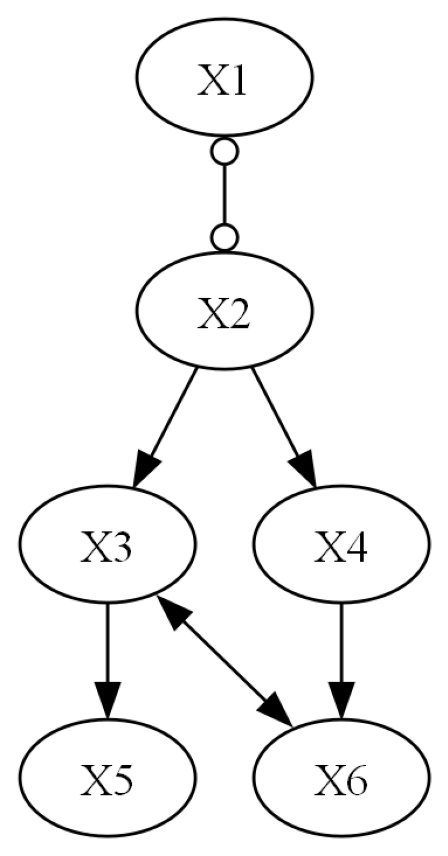

In [545]:
cluster_cg.draw_pydot_graph()

In [546]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(5)
# node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 429.59it/s] 

X3 --> X5


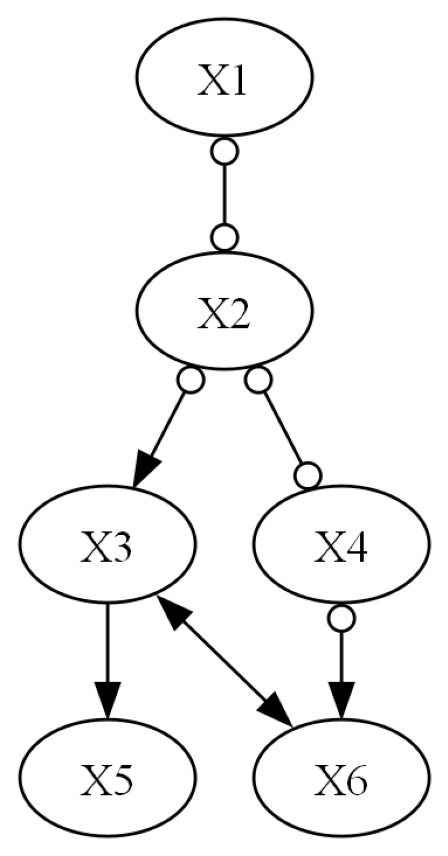

In [547]:
base_cg.draw_pydot_graph()

In [548]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 6, 'false_positive': 0, 'false_negative': 0, 'true_negative': 9, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 5.0, 'false_positive': 0.0, 'false_negative': 3.0, 'true_negative': 28.0, 'precision': 1.0, 'recall': 0.625, 'f1_score': 0.7692307692307693, 'true_positive_ce': 5.0, 'false_positive_ce': 0.0, 'false_negative_ce': 3.0, 'true_negative_ce': 28.0, 'precision_ce': 1.0, 'recall_ce': 0.625, 'f1_score_ce': 0.7692307692307693}
SHD:  2
SID:  {'sid_lower': None}


In [549]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 6, 'false_positive': 0, 'false_negative': 0, 'true_negative': 9, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 6.0, 'false_positive': 0.0, 'false_negative': 2.0, 'true_negative': 28.0, 'precision': 1.0, 'recall': 0.75, 'f1_score': 0.8571428571428571, 'true_positive_ce': 6.0, 'false_positive_ce': 0.0, 'false_negative_ce': 2.0, 'true_negative_ce': 28.0, 'precision_ce': 1.0, 'recall_ce': 0.75, 'f1_score_ce': 0.8571428571428571}
SHD:  2
SID:  {'sid_lower': None}


### 6 node FCI No.3

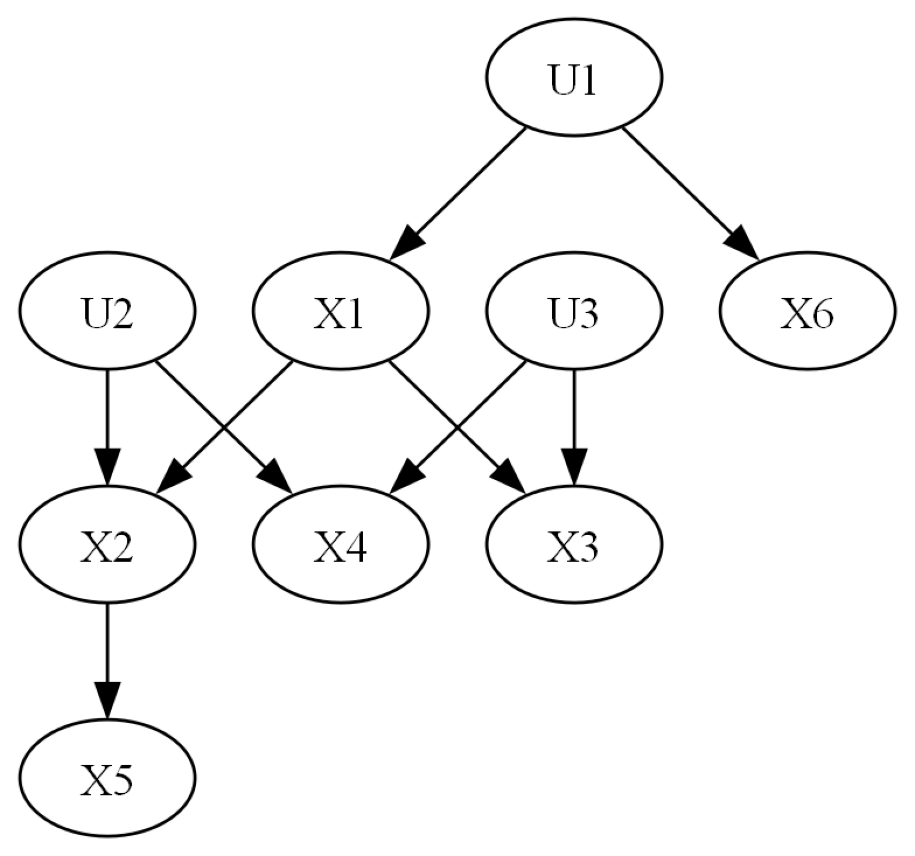

In [577]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "X5", "X6", "U1", "U2", "U3"]

# Parent dictionary
# Make sure nodes are put into topological ordering
parent_dict = {
    "X1": ["U1"],           
    "X2": ["X1", "U2"],
    "X3": ["X1", "U3"],               
    "X4": ["U2", "U3"], 
    "X5": ["X2"],
    "X6": ["U1"],
    "U1": [],
    "U2": [],
    "U3": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [578]:
true_mag = truth
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U1', cg = truth))
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U2', cg = truth))
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U3', cg = truth))
# Add edge due to inducing path
node1 = ClusterDAG.get_node_by_name('X1', cg = truth)
node2 = ClusterDAG.get_node_by_name('X6', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)
# Add bidirected edges due to latent confounding
node1 = ClusterDAG.get_node_by_name('X2', cg = truth)
node2 = ClusterDAG.get_node_by_name('X3', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)
node1 = ClusterDAG.get_node_by_name('X3', cg = truth)
node2 = ClusterDAG.get_node_by_name('X4', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)

True

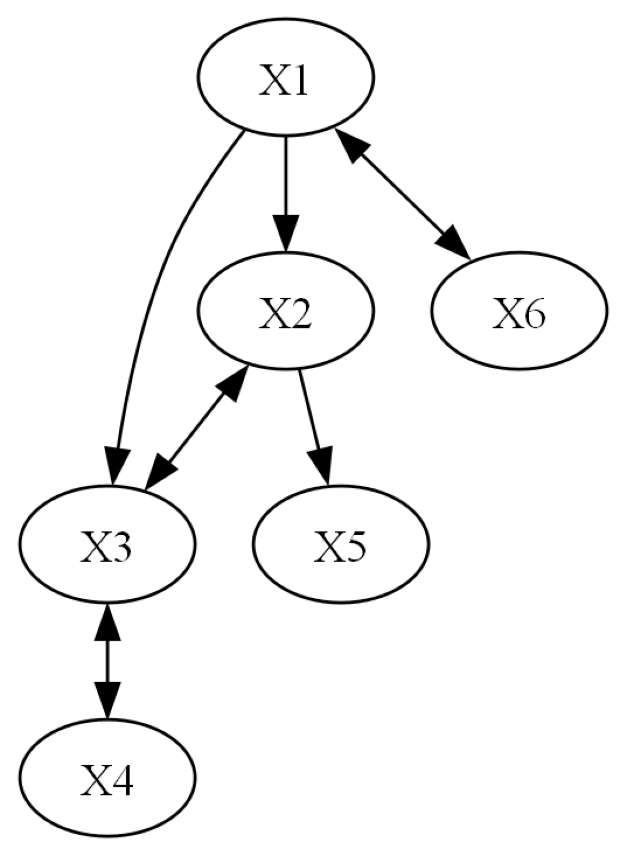

In [579]:
true_mag.draw_pydot_graph()

In [580]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([ 2.07592697,  2.7050974 ,  2.25414112,  1.8209902 ,  2.47094402,
        1.34507586,  1.57921282,  0.76743473, -0.46947439])

In [581]:
# remove confounders from X
X = X[:,:6]
X

array([[ 2.07592697,  2.7050974 ,  2.25414112,  1.8209902 ,  2.47094402,
         1.34507586],
       [-0.01972749, -1.4959763 , -0.17120991, -0.45662152, -3.40925654,
        -2.28720536],
       [-1.4524068 , -2.75378791, -1.13775161, -1.26584729, -2.68625971,
        -1.96913091],
       ...,
       [ 0.36195746, -2.15557537,  1.51389277,  2.0082814 , -2.29978207,
         2.94309945],
       [ 2.84977439,  3.05742378,  3.06222901, -1.24619098,  1.4169281 ,
         0.75125336],
       [ 0.82388967,  0.80153437,  0.95269842, -1.94598947,  2.62356506,
        -0.96590443]])

In [582]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']}, \
#                          cluster_edges = [])

In [583]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4', 'X5', 'X6']}, \
#                          cluster_edges = [('C1', 'C2')])

In [607]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C2'), ('C1', 'C3')], \
                         cluster_bidirected_edges= [('C1', 'C2'), ('C1', 'C3')])

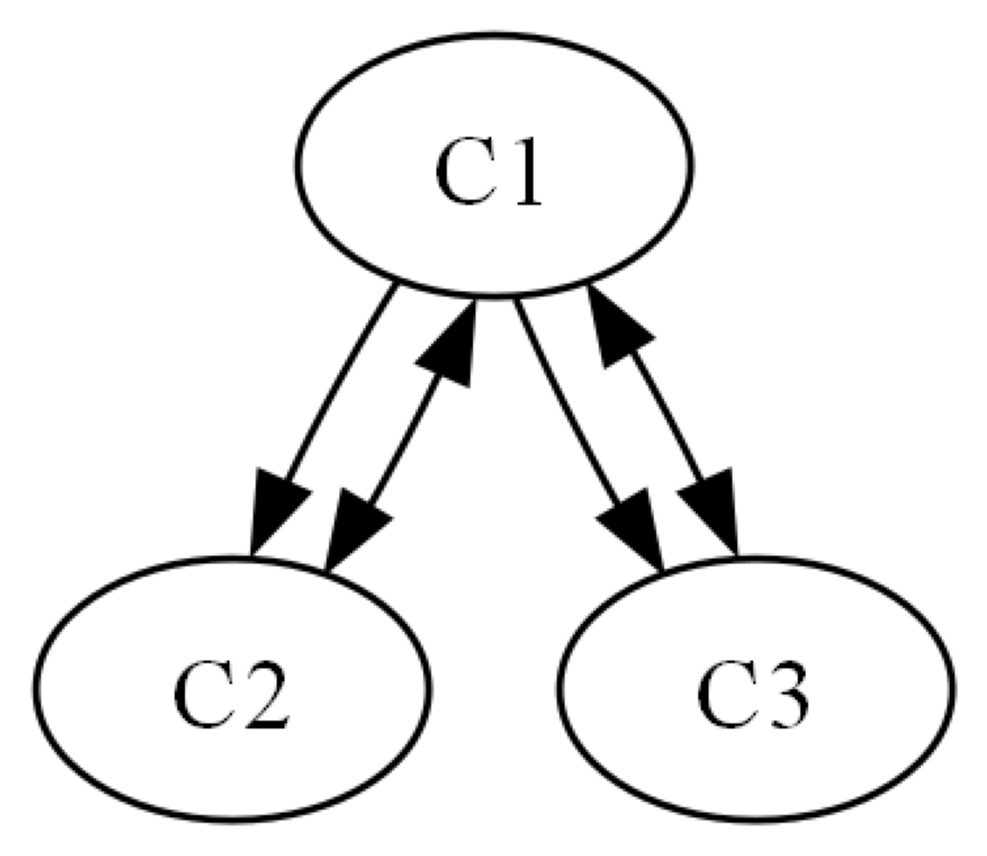

In [608]:
cluster_dag.cluster_graph.draw_pydot_graph()

Found inducing path between C2 and C3: ['C2', 'C1', 'C3']
Found inducing path between C3 and C2: ['C3', 'C1', 'C2']


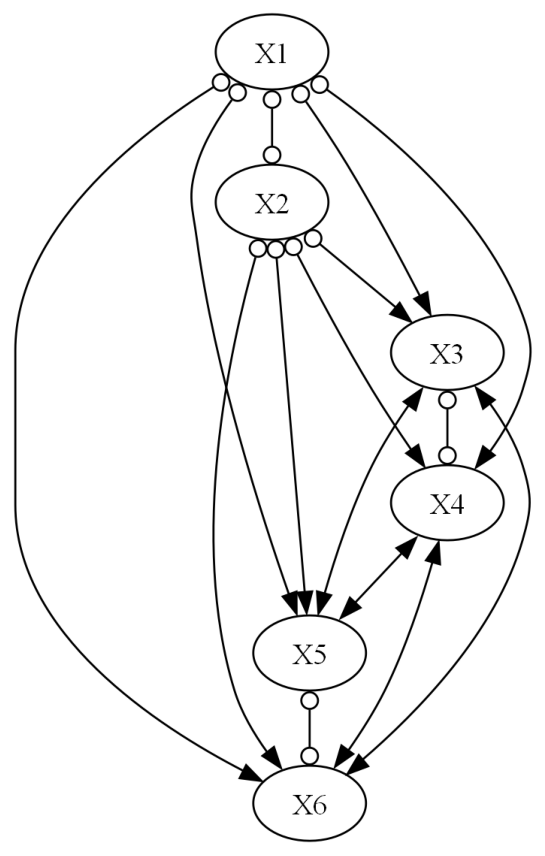

In [609]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [610]:
cluster_dag.bidir_paths

{'C1': [['C1'], ['C1', 'C2'], ['C1', 'C3']],
 'C2': [['C2'], ['C2', 'C1'], ['C2', 'C1', 'C3']],
 'C3': [['C3'], ['C3', 'C1'], ['C3', 'C1', 'C2']]}

In [611]:
cluster_dag.collider_paths

{'C1': [['C1'], ['C1', 'C2'], ['C1', 'C3']],
 'C2': [['C2'], ['C2', 'C1'], ['C2', 'C1', 'C3']],
 'C3': [['C3'], ['C3', 'C1'], ['C3', 'C1', 'C2']]}

In [612]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

Found inducing path between C2 and C3: ['C2', 'C1', 'C3']
Found inducing path between C3 and C2: ['C3', 'C1', 'C2']


In [613]:
cluster_cg, cluster_edges = cluster_fci.run()

C3 phase, Depth=2, working on node 5: 100%|██████████| 2/2 [00:00<00:00, 364.79it/s, duration: 0.02sec]

X2 --> X5


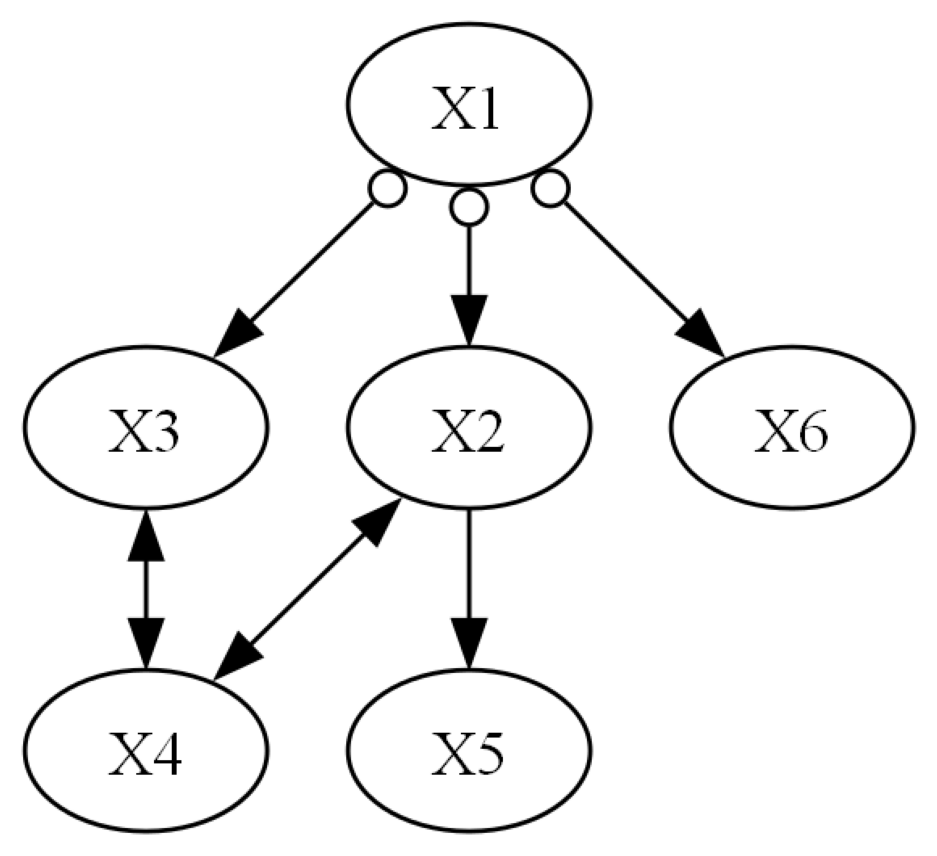

In [614]:
cluster_cg.draw_pydot_graph()

In [615]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(5)
# node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<?, ?it/s]         

X2 --> X5


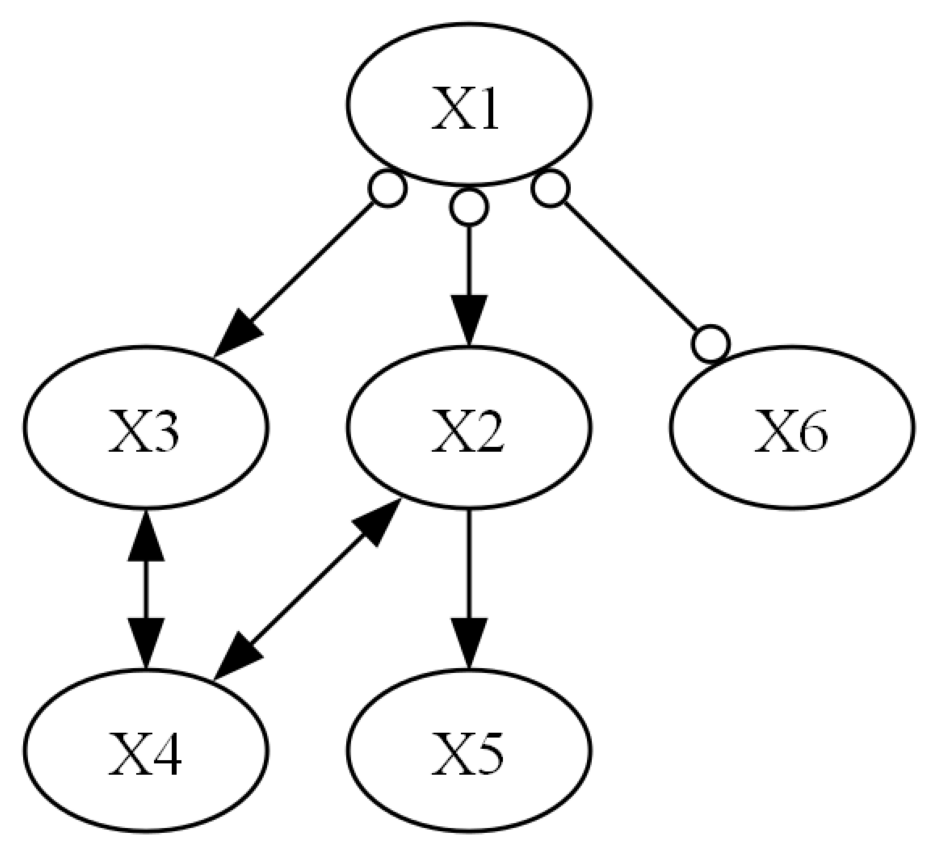

In [616]:
base_cg.draw_pydot_graph()

In [617]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 5, 'false_positive': 1, 'false_negative': 1, 'true_negative': 8, 'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1_score': 0.8333333333333334}
Arrow confusion:  {'true_positive': 5.0, 'false_positive': 2.0, 'false_negative': 4.0, 'true_negative': 25.0, 'precision': 0.7142857142857143, 'recall': 0.5555555555555556, 'f1_score': 0.6250000000000001, 'true_positive_ce': 5.0, 'false_positive_ce': 0.0, 'false_negative_ce': 2.0, 'true_negative_ce': 29.0, 'precision_ce': 1.0, 'recall_ce': 0.7142857142857143, 'f1_score_ce': 0.8333333333333333}
SHD:  4
SID:  {'sid_lower': None}


In [618]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 5, 'false_positive': 1, 'false_negative': 1, 'true_negative': 8, 'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1_score': 0.8333333333333334}
Arrow confusion:  {'true_positive': 6.0, 'false_positive': 2.0, 'false_negative': 3.0, 'true_negative': 25.0, 'precision': 0.75, 'recall': 0.6666666666666666, 'f1_score': 0.7058823529411765, 'true_positive_ce': 6.0, 'false_positive_ce': 0.0, 'false_negative_ce': 1.0, 'true_negative_ce': 29.0, 'precision_ce': 1.0, 'recall_ce': 0.8571428571428571, 'f1_score_ce': 0.923076923076923}
SHD:  5
SID:  {'sid_lower': None}
